In [1]:
import os

# 1) ENV VARS – before any TF import
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.3"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.3"

# 2) Sanity check
print("XLA_FLAGS:",    os.environ["XLA_FLAGS"])
print("Looking here:", os.path.exists(
    "/usr/local/cuda-12.3/nvvm/libdevice/libdevice.10.bc"
))


XLA_FLAGS: --xla_gpu_cuda_data_dir=/usr/local/cuda-12.3
Looking here: True


In [3]:
import sys
import tensorflow as tf

sys.path.insert(0, "/tmp/wandb_pkg")
import wandb
print("wandb version:", wandb.__version__)

# avoid matplotlib cache errors
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
# suppress TF INFO logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

wandb version: 0.19.10


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
import psutil
import subprocess
import GPUtil

# Enable script imports
sys.path.append(os.path.abspath(".."))

from scripts.data_loader import save_tokenize_data, MAX_VOCAB_SIZE, MAX_SEQ_LEN
from scripts.result_logger import log_results 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)

#import wandb
#from wandb.integration.keras import WandbCallback 
import wandb.integration.keras as wbk
print(dir(wbk))
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
print("wandb version:", wandb.__version__)
print("wandb package path:", wandb.__file__)


['WandbCallback', 'WandbEvalCallback', 'WandbMetricsLogger', 'WandbModelCheckpoint', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'callbacks', 'keras']
wandb version: 0.19.10
wandb package path: /tmp/wandb_pkg/wandb/__init__.py


In [7]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load pre-processed data splits 
X_train_seq = np.load("../data/splits/X_train_seq.npy")
X_val_seq = np.load("../data/splits/X_val_seq.npy")
X_test_seq = np.load("../data/splits/X_test_seq.npy")
y_train_bin = np.load("../data/splits/y_train_bin.npy")
y_val_bin = np.load("../data/splits/y_val_bin.npy")
y_test_bin = np.load("../data/splits/y_test_bin.npy")

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("No GPU found.")
tf.config.experimental.set_memory_growth(gpus[0], True)
print("GPU ready:", gpus[0])


#  Best hyperparameters from sweep (wuh1gf90)
BEST_CONFIG = {
    "model": "CNN",
    "dataset": "Sentiment140",
    'batch_size': 256,
    'dense_units': 64,
    'dropout': 0.2,
    'embedding_dim': 256,
    'epochs': 5,
    'kernel_size': 3,
    'learning_rate': 0.0005,
    'num_filters': 256,
    'optimizer': "adam"
}

GPU ready: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# CNN

In [8]:
# wandb Init
wandb.init(
    project="sentiment-analysis", 
    name="CNN_Social", 
    config=BEST_CONFIG,
)

wbcfg = wandb.config

2025/04/30 15:43:54 ERROR failed to get logger path error="error creating log directory: mkdir /home/smpandit/.cache/wandb: disk quota exceeded"
2025/04/30 15:43:54 INFO Will exit if parent process dies. ppid=540292
2025/04/30 15:43:54 INFO server is running addr=127.0.0.1:42781
2025/04/30 15:43:55 INFO connection: ManageConnectionData: new connection created id=127.0.0.1:53556
wandb: Currently logged in as: smpandit (smpandit-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
2025/04/30 15:43:55 INFO handleInformInit: received streamId=y27fqo2t id=127.0.0.1:53556
2025/04/30 15:43:55 INFO handleInformInit: stream started streamId=y27fqo2t id=127.0.0.1:53556


In [9]:
# Tensorboard logging

log_dir = f"logs/{wandb.run.name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
callbacks = [
    wbk.WandbMetricsLogger(),                    # logs train metrics
    #WandbModelCheckpoint(save_model=False),  # logs model checkpoints
    #wbk.WandbEvalCallback(),                     # logs val metrics
    tensorboard_callback,
]

In [12]:
# Build CNN model

cnn_model = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE, 
        output_dim=wbcfg.embedding_dim, 
        input_length=MAX_SEQ_LEN
    ),
    Conv1D(
        filters=wbcfg.num_filters,
        kernel_size=wbcfg.kernel_size,
        activation='relu'
    ),              
    GlobalMaxPooling1D(),
    Dense(wbcfg.dense_units, activation='relu'),                   
    Dropout(wbcfg.dropout),
    Dense(1, activation='sigmoid')                   
])

# Compile CNN model
opt = Adam(learning_rate=wbcfg.learning_rate)

cnn_model.compile(
    optimizer=opt, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)                   

/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746053250.258143  540292 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 75541 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:03:00.0, compute capability: 8.0


In [ ]:
# Train CNN model

start_time = time.time()

history = cnn_model.fit(
    X_train_seq, 
    y_train_bin,
    validation_data=(
        X_val_seq, 
        y_val_bin
    ),
    epochs=wbcfg.epochs,
    batch_size=wbcfg.batch_size,
    callbacks=[
        #tensorboard_callback, 
        #WandbCallback()
        #callbacks()                                     #TODO
    ],
    verbose=1
)

train_time = time.time() - start_time

Epoch 1/5


I0000 00:00:1746053255.519180  546166 service.cc:152] XLA service 0x7fe918003bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746053255.519222  546166 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1746053255.793323  546166 cuda_dnn.cc:529] Loaded cuDNN version 90800


  30/4364 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.5475 - loss: 0.6888 

I0000 00:00:1746053259.574271  546166 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4364/4364 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.7836 - loss: 0.4533 - val_accuracy: 0.8211 - val_loss: 0.3935
Epoch 2/5
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.8314 - loss: 0.3760 - val_accuracy: 0.8219 - val_loss: 0.3917
Epoch 3/5
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.8537 - loss: 0.3347 - val_accuracy: 0.8171 - val_loss: 0.4160
Epoch 4/5
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.8771 - loss: 0.2879 - val_accuracy: 0.8111 - val_loss: 0.4622
Epoch 5/5
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.8984 - loss: 0.2427 - val_accuracy: 0.8067 - val_loss: 0.5440


In [14]:
# Validation Evaluation
y_val_preds_cnn = (cnn_model.predict(X_val_seq) > 0.5).astype("int32")

print("\n CNN Model - Validation Set:")
print(classification_report(y_val_bin, y_val_preds_cnn))

val_acc = accuracy_score(y_val_bin, y_val_preds_cnn)
val_prec = precision_score(y_val_bin, y_val_preds_cnn)
val_rec = recall_score(y_val_bin, y_val_preds_cnn)
val_f1 = f1_score(y_val_bin, y_val_preds_cnn)

7483/7483 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step

 CNN Model - Validation Set:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81    119762
           1       0.82      0.78      0.80    119680

    accuracy                           0.81    239442
   macro avg       0.81      0.81      0.81    239442
weighted avg       0.81      0.81      0.81    239442



In [15]:
# Test Evaluation
y_test_preds_cnn = (cnn_model.predict(X_test_seq) > 0.5).astype("int32").flatten()

print("\n CNN Model - Test Set:")
print(classification_report(y_test_bin, y_test_preds_cnn))

acc = accuracy_score(y_test_bin, y_test_preds_cnn)
prec = precision_score(y_test_bin, y_test_preds_cnn)
rec = recall_score(y_test_bin, y_test_preds_cnn)
f1 = f1_score(y_test_bin, y_test_preds_cnn)


7482/7482 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step

 CNN Model - Test Set:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81    119742
           1       0.82      0.78      0.80    119660

    accuracy                           0.81    239402
   macro avg       0.81      0.81      0.81    239402
weighted avg       0.81      0.81      0.81    239402



In [16]:
# Inference time 
start_infer = time.time()
test_preds = (cnn_model.predict(X_test_seq) > 0.5).astype("int32")
infer_time = (time.time() - start_infer) / len(X_test_seq)  # avg per sample

7482/7482 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


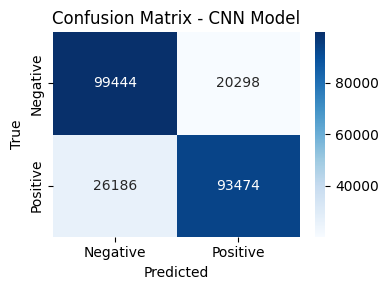

In [17]:
# Confusion Matrix

cm = confusion_matrix(y_test_bin, y_test_preds_cnn, labels=[0, 1])
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("cnn_confusion_matrix.png")

In [18]:
# Systems Stats

cpu_usage = psutil.cpu_percent(interval=1)
mem_usage = psutil.virtual_memory().percent
gpu = GPUtil.getGPUs()[0]
power = subprocess.check_output([
    "nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"
]).decode("utf-8").strip()

In [21]:
# Log results to  result_logger.py & wandb Logs

log_results(
    model_name="CNN",
    dataset_name="Social Media",
    accuracy=acc,
    precision=prec,
    recall=rec,
    f1=f1,
    tuning_time=None,
    train_time=train_time,
    inference_time=infer_time,
    latency=infer_time * 1000,
    cpu_usage=cpu_usage,
    mem_usage=mem_usage,
    gpu_usage=gpu.load * 100,
    gpu_mem_usage=gpu.memoryUtil * 100,
    gpu_temp=gpu.temperature,
    power=float(power),
    num_features=MAX_VOCAB_SIZE,
    hyperparams=f"embed_dim={wbcfg.embedding_dim}, epochs={wbcfg.epochs}, batch={wbcfg.batch_size}"
)

wandb.log({
    "Validation Accuracy": val_acc, 
    "Validation Precision": val_prec,
    "Validation Recall": val_rec, 
    "Validation F1 Score": val_f1,

    "Test Accuracy": acc,
    "Test Precision": prec,
    "Test Recall": rec,
    "Test F1": f1,

    "Training Time (s)": train_time,
    "Inference Time (s)": infer_time,
    "Latency (ms)": infer_time * 1000,

    "CPU Usage (%)": cpu_usage,
    "Memory Usage (%)": mem_usage,
    "GPU Load (%)": gpu.load * 100,
    "GPU Memory (%)": gpu.memoryUtil * 100,
    "GPU Temp": gpu.temperature,
    "Power Consumption (W)": float(power),

    "Confusion Matrix": wandb.Image("cnn_confusion_matrix.png")
})
wandb.finish()


Logged: CNN on Social Media to ../results/results.csv


/research2/smpandit/Sentiment_Analysis_ML_DL_LLM/scripts/result_logger.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row_df], ignore_index=True)


CPU Usage (%),▁
GPU Load (%),▁
GPU Memory (%),▁
GPU Temp,▁
Inference Time (s),▁
Latency (ms),▁
Memory Usage (%),▁
Power Consumption (W),▁
Test Accuracy,▁
Test F1,▁
Test Precision,▁


2025/04/30 15:57:48 INFO handleInformFinish: finish message received streamId=y27fqo2t id=127.0.0.1:53556
2025/04/30 15:57:48 INFO handleInformFinish: stream closed streamId=y27fqo2t id=127.0.0.1:53556


# BiLSTM

In [ ]:
#BiLSTM

model = Sequential([
    Embedding(max_vocab, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
